# data preperation

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

sns.set_theme(style="dark")

In [37]:
dfBTC = pd.read_csv('bitcoin_data.csv')
dfXTZ = pd.read_csv('tezos_data.csv')


#rename volume marketcap and price
dfBTC = dfBTC.rename(columns={'volume': 'btc_volume','market_cap': 'btc_market_cap','price': 'btc_price'  })
dfXTZ = dfXTZ.rename(columns={'volume': 'xtz_volume','market_cap': 'xtz_market_cap','price': 'xtz_price' })


# conver to datetime
dfXTZ['date'] = pd.to_datetime(dfXTZ['date'])
dfBTC['date'] = pd.to_datetime(dfBTC['date'])

print(dfBTC.size, dfXTZ.size)
dfXTZ.head()

17592 10032


,date,xtz_price,xtz_market_cap,xtz_volume
0,2018-07-03,2.937866,0.000000e+00,3.172538e+06
1,2018-07-04,2.047985,0.000000e+00,1.426545e+07
2,2018-07-05,1.969392,1.196384e+09,6.492796e+06
3,2018-07-06,1.528033,9.282631e+08,8.681129e+06
4,2018-07-07,1.796304,1.091235e+09,1.617507e+07


# cleaning

In [38]:
#Filter dates so only days where theres values on both days will be used

dfBTCfiltered = dfBTC[dfBTC['date'].isin(dfXTZ['date'])]
dfXTZfiltered = dfXTZ[dfXTZ['date'].isin(dfBTCfiltered['date'])]

print(dfBTCfiltered.size,dfXTZfiltered.size)

10032 10032


In [39]:
#sort on dates if it wasnt already
dfBTCfiltered = dfBTCfiltered.sort_values('date').reset_index(drop=True)
dfXTZfiltered = dfXTZfiltered.sort_values('date').reset_index(drop=True)


Merge

In [40]:
df = pd.DataFrame({
    'date': dfBTCfiltered['date'],
    'btc_price': dfBTCfiltered['btc_price'],
    'xtz_price': dfXTZfiltered['xtz_price'],
    'btc_volume': dfBTCfiltered['btc_volume'],
    'xtz_volume': dfXTZfiltered['xtz_volume'],
    'btc_market_cap': dfBTCfiltered['btc_market_cap'],
    'xtz_market_cap': dfXTZfiltered['xtz_market_cap'],
})


# Add returns as features
df['btc_return'] = df['btc_price'].pct_change()
df['xtz_return'] = df['xtz_price'].pct_change()

# Add target (Tezos price tomorrow)
df['xtz_target'] = df['xtz_price'].shift(-1)

# Drop NaNs created by shift and pct_change
df.dropna(inplace=True)

df.head()

,date,btc_price,xtz_price,btc_volume,xtz_volume,btc_market_cap,xtz_market_cap,btc_return,xtz_return,xtz_target
1,2018-07-04,6497.607355,2.047985,3.013787e+09,1.426545e+07,1.113016e+11,0.000000e+00,-0.014849,-0.302900,1.969392
2,2018-07-05,6562.721737,1.969392,3.111969e+09,6.492796e+06,1.124279e+11,1.196384e+09,0.010021,-0.038376,1.528033
3,2018-07-06,6537.740872,1.528033,3.315115e+09,8.681129e+06,1.120110e+11,9.282631e+08,-0.003806,-0.224109,1.796304
4,2018-07-07,6603.294704,1.796304,4.742128e+09,1.617507e+07,1.131475e+11,1.091235e+09,0.010027,0.175567,1.844640
5,2018-07-08,6759.836089,1.844640,6.047929e+09,5.530662e+06,1.158427e+11,1.120599e+09,0.023707,0.026909,2.361797


Since we are trying to predict the price of XTZ, xtz_target is our target. 

In [41]:
features = df[[
    'btc_price',
    'xtz_price',
    'btc_volume',
    'xtz_volume',
    'btc_return',
    'xtz_return'
]]
target = df['xtz_target']

Make a Train/Test split, we wont shuffle the data, as we want to keep the time series order.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, shuffle=False
)

X_train_lr = X_train.copy()
X_train_rf = X_train.copy()
X_train_xgb = X_train.copy()

X_test_lr = X_test.copy()
X_test_rf = X_test.copy()
X_test_xgb = X_test.copy()

y_train_lr = y_train.copy()
y_train_rf = y_train.copy()
y_train_xgb = y_train.copy()

y_test_lr = y_test.copy()
y_test_rf = y_test.copy()
y_test_xgb = y_test.copy()

In [43]:
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

## Linear Regression

In [44]:

model = LinearRegression()
model.fit(X_train_lr, y_train_lr)

y_pred_lr = model.predict(X_test_lr)


In [45]:
# Store original feature names before scaling
feature_names = X_train.columns

# Compute metrics
rmse_lr = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
r2_lr = r2_score(y_test_lr, y_pred_lr)

print("RMSE:", rmse_lr)  # RMSE: 0.07126667049068093
print("R² Score:", r2_lr)  # R² Score: 0.9365436049015705

# Create sorted DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
})
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)
print(coef_df)



RMSE: 0.07126667049068093
R² Score: 0.9365436049015705
      Feature  Coefficient  AbsCoefficient
1   xtz_price     1.520670        1.520670
2  btc_volume     0.012054        0.012054
0   btc_price     0.006988        0.006988
5  xtz_return    -0.006004        0.006004
3  xtz_volume    -0.001583        0.001583
4  btc_return     0.001403        0.001403


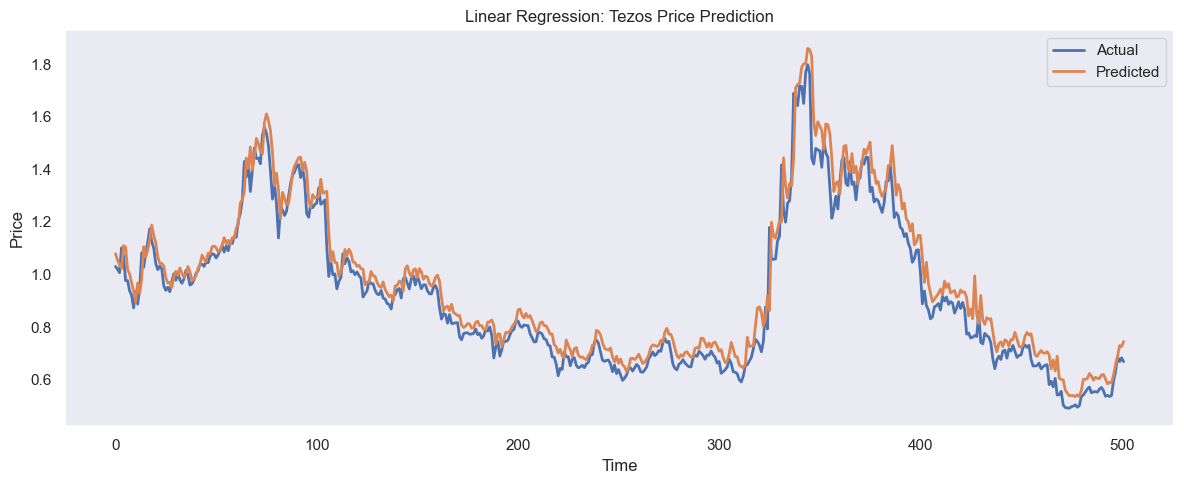

In [46]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_lr.values, label='Actual', linewidth=2)
plt.plot(y_pred_lr, label='Predicted', linewidth=2)
plt.title('Linear Regression: Tezos Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


## Random Forest

In [47]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test_rf)

rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
r2_rf = r2_score(y_test_rf, y_pred_rf)

print(f'RMSE: {rmse_rf:.4f}') # RMSE: 0.0545
print(f'R² Score: {r2_rf:.4f}') #R² Score: 0.9628

RMSE: 0.0545
R² Score: 0.9628


## Feature Importance

In [48]:
feature_names = X_train.columns
importances = rf.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df['Importance'] = importance_df['Importance'].round(4)
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(importance_df)

      Feature  Importance
0   xtz_price      0.9957
1   btc_price      0.0011
2  btc_volume      0.0009
3  btc_return      0.0009
4  xtz_volume      0.0007
5  xtz_return      0.0007


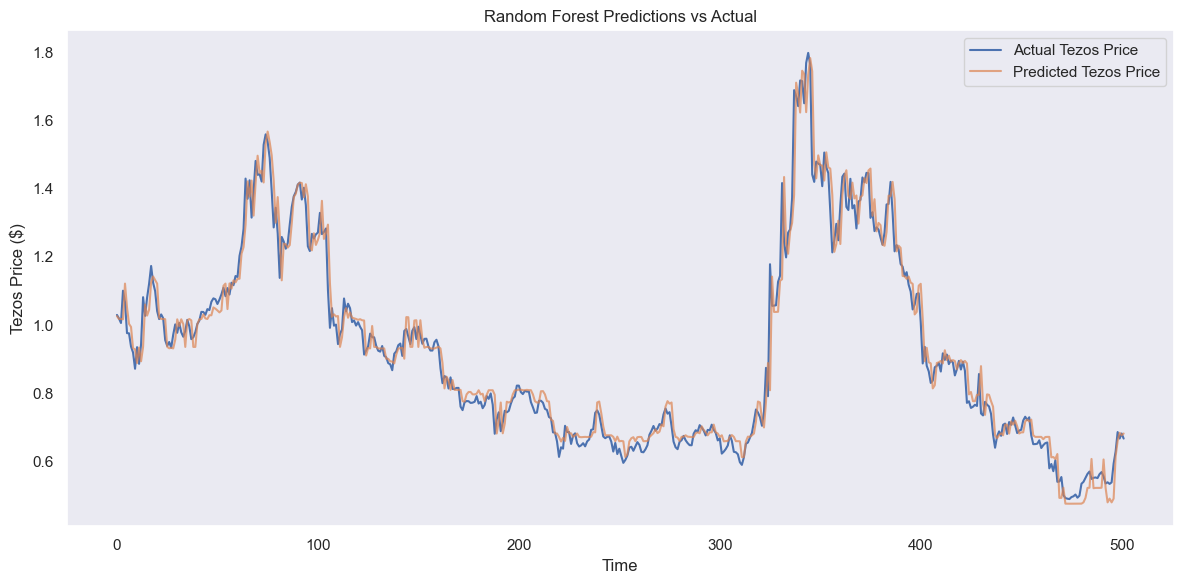

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rf.values, label='Actual Tezos Price')
plt.plot(y_pred_rf, label='Predicted Tezos Price', alpha=0.7)
plt.title('Random Forest Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Tezos Price ($)')
plt.legend()
plt.tight_layout()
plt.show()

# XG BOOST

In [50]:
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# # tuner parameter grid
# param_grid = {
#     'min_child_weight':[1, 3, 5, 10],
#     'gamma':[0, 0.1, 0.5, 1],
#     'n_estimators': [100, 200,300,500],
#     'max_depth': [3, 4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.6, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9,1],
#     'reg_alpha': [0, 0.01, 0.1, 1],
# 'reg_lambda': [0.5, 1, 2]

# }

# tscv = TimeSeriesSplit(n_splits=5)

# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# # Grid search with time series cross-validation
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=tscv,
#     verbose=True,
#     n_jobs=-1
# )

# grid_search.fit(X_train_xgb, y_train_xgb)

# print("Best parameters:", grid_search.best_params_)
# print("Best score (negative MSE):", grid_search.best_score_)


# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test_xgb)

# rmse_best_XGBoost = mean_squared_error(y_test_xgb, y_pred_best)
# r2_best_XGBoost = r2_score(y_test_xgb, y_pred_best)

# print(f"Tuned Model RMSE: {rmse_best_XGBoost:.4f}")
# print(f"Tuned Model R²: {r2_best_XGBoost:.4f}")


In [51]:
# Best parameters from GridSearchCV (with slight adjustments for overfitting)
best_params = {
    'colsample_bytree': 1.0,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 100,
    'subsample': 1
}

# Time series split is no longer needed here, since we’re fitting directly
# Initialize model with best params
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)

xgb_model.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = xgb_model.predict(X_test_xgb)

rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
r2_xgb = r2_score(y_test_xgb, y_pred_xgb)

print(f"Final Model RMSE: {rmse_xgb:.4f}") # 0.0744
print(f"Final Model R²: {r2_xgb:.4f}") # 0.9308

feature_names = X_train.columns
importances = xgb_model.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df['Importance'] = importance_df['Importance'].round(4)
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(importance_df)

Final Model RMSE: 0.1103
Final Model R²: 0.8480
      Feature  Importance
0   xtz_price      0.9814
1   btc_price      0.0051
2  xtz_return      0.0039
3  btc_return      0.0034
4  btc_volume      0.0032
5  xtz_volume      0.0030


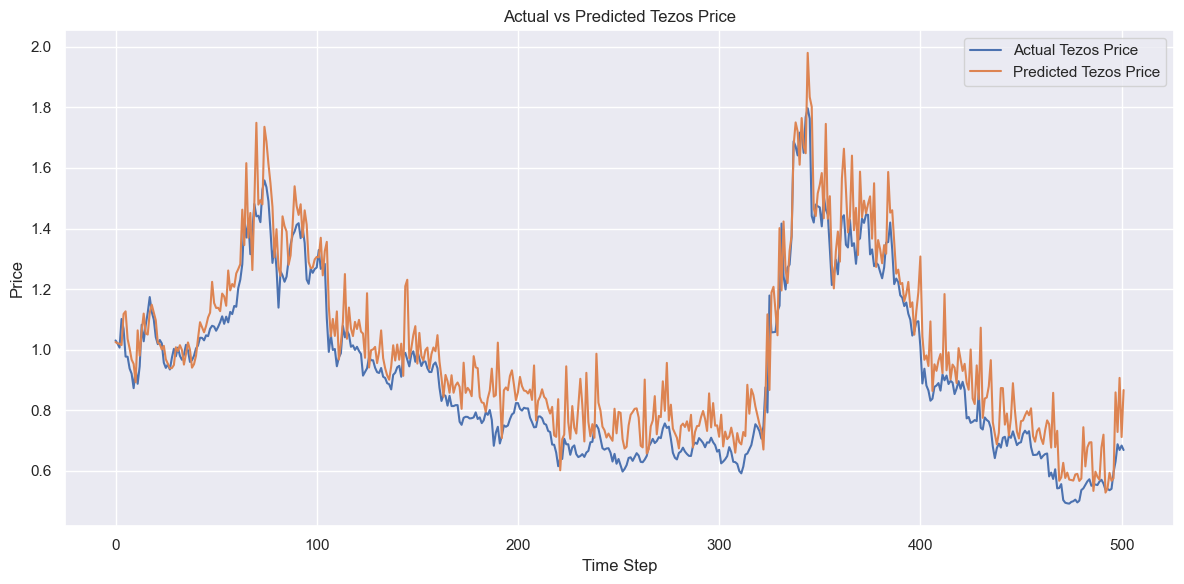

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_xgb.values, label='Actual Tezos Price')
plt.plot(y_pred_xgb, label='Predicted Tezos Price')
plt.title('Actual vs Predicted Tezos Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Conclusion

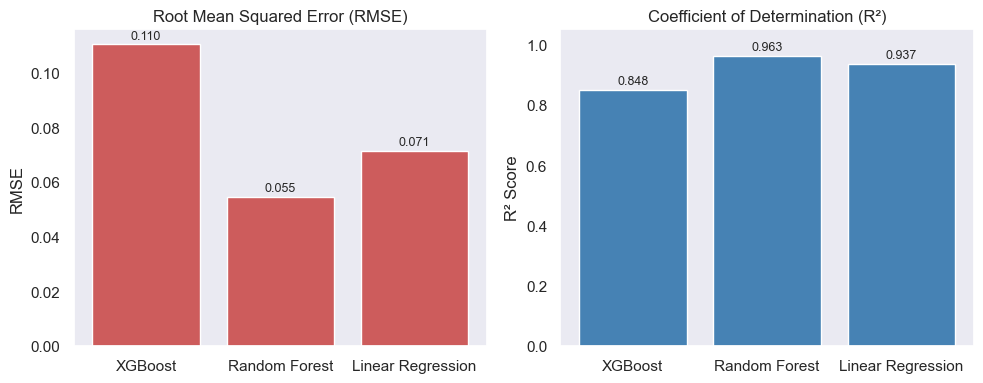

In [53]:
data = {
    'XGBoost': {'RMSE': rmse_xgb, 'R²': r2_xgb},
    'Random Forest': {'RMSE': rmse_rf, 'R²': r2_rf},
    'Linear Regression': {'RMSE': rmse_lr, 'R²': r2_lr}
}

df = pd.DataFrame(data).T

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(df.index, df['RMSE'], color='indianred')
axes[0].set_title('Root Mean Squared Error (RMSE)')
axes[0].set_ylabel('RMSE')
for i, val in enumerate(df['RMSE']):
    axes[0].text(i, val + 0.001, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

axes[1].bar(df.index, df['R²'], color='steelblue')
axes[1].set_title('Coefficient of Determination (R²)')
axes[1].set_ylabel('R² Score')
axes[1].set_ylim(0, 1.05)

for i, val in enumerate(df['R²']):
    axes[1].text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Check for overfitting

In [54]:
# TRAIN predictions
y_pred_train_xgb = xgb_model.predict(X_train_xgb)
y_pred_train_rf = rf.predict(X_train_rf)
y_pred_train_lr = model.predict(X_train_lr)

# TEST predictions
y_pred_test_xgb = xgb_model.predict(X_test_xgb)
y_pred_test_rf = rf.predict(X_test_rf)
y_pred_test_lr = model.predict(X_test_lr)

# Error metrics
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

metrics = {
    "XGBoost": {
        "Train": evaluate(y_train, y_pred_train_xgb),
        "Test": evaluate(y_test, y_pred_test_xgb)
    },
    "Random Forest": {
        "Train": evaluate(y_train, y_pred_train_rf),
        "Test": evaluate(y_test, y_pred_test_rf)
    },
    "Linear Regression": {
        "Train": evaluate(y_train, y_pred_train_lr),
        "Test": evaluate(y_test, y_pred_test_lr)
    }
}

for model, result in metrics.items():
    print(f"\n{model}:")
    print(f"  Train RMSE: {result['Train'][0]:.4f}, R²: {result['Train'][1]:.4f}")
    print(f"  Test  RMSE: {result['Test'][0]:.4f}, R²: {result['Test'][1]:.4f}")


XGBoost:
  Train RMSE: 0.0963, R²: 0.9961
  Test  RMSE: 0.1103, R²: 0.8480

Random Forest:
  Train RMSE: 0.1401, R²: 0.9917
  Test  RMSE: 0.0545, R²: 0.9628

Linear Regression:
  Train RMSE: 0.1826, R²: 0.9860
  Test  RMSE: 0.0713, R²: 0.9365
